In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import urllib.request
import os
import math
import emcee
from astroML.plotting import plot_mcmc

# for downloading 
def download(PATH,local_name,format_offile):
    '''This function takes PATH which is url of file and local_name i.e the name of file after downloaded and format
    file and downloads the file from web and stores in your path'''
    local_path=os.path.join("./",f'{local_name}.{format_offile}')
    urllib.request.urlretrieve(PATH,local_path)

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<p>Q1. In 1919, two expeditions sailed from Britain to test if the light deflection from stars agrees with Einstein’s General Theory of Relativity. Einstein’s theory predicts a value of 1.74 arc-seconds, whereas Newtonian gravity predicts a value exactly half of that. The team by Eddington obtained a value of 1.61 ± 0.40 arc-seconds, while the team by Crommelin reported a value of 1.98 ± 0.16 arc-seconds. Calculate the Bayes factor between General Relativity and Newtonian gravity from those data, assuming Gaussian likelihoods.</p>

<p>Reformulation of given problem : Here we have two theories(models namely Einstein theory and Netw) that we have to check to observations favoring which model prediction using bayes model selection (Bayes factor). Eddignton one is gaussian distributed with 1.61 as mean and 0.4 as standard deviation (considering 1sigma as significance) and Crommelin corresponds to Gaussian distribution with mean 1.98 and standard deviation of 0.16.</p>

<p>By eye, we can say that Einstein is correct as the predicts are more nearer and we expect Bayes factor between General Relativity and Newtonian (General Relativity model top) to be more than 100 as it is decisive that General Relativity is most favoured.</p>

In [2]:
eddington_value,error_eddington=1.61,0.4
crommelin_value,error_crommelin=1.98,0.16 # we have only two samples as our data 

einstein_value=1.74
newtonian_value=(einstein_value/2)

# Chi-squared values
chi2_GR = ((eddington_value - einstein_value)/error_eddington)**2+((crommelin_value - einstein_value)/error_crommelin)**2
chi2_NG = ((eddington_value - newtonian_value)/error_eddington)**2+((crommelin_value - newtonian_value)/error_crommelin)**2

# Marginal likelihoods
marginal_likelihood_GR = (1/(2*np.pi*error_eddington*error_crommelin))*np.exp(-(chi2_GR/2))
marginal_likelihood_NG = (1/(2*np.pi*error_eddington*error_crommelin))*np.exp(-(chi2_NG/2))

# Bayes factor
K = marginal_likelihood_GR / marginal_likelihood_NG

print("Bayes factor between General Relativity and Newtonian Gravity:", K)

Bayes factor between General Relativity and Newtonian Gravity: 48164622958.34176


<p>As expected we get the Bayes factor(K) > 100 which means Model 1 (General Relativity) is decisively favoured than Model 2 (Newtonian Gravity). Even in that paper it was argued that they have strongly accepted Einstein hypothesis over Newtonian. Now considering individual values then we have,</p>

In [3]:
eddington_value,error_eddington=1.61,0.4
crommelin_value,error_crommelin=1.98,0.16 # we have only two samples as our data 

einstein_value=1.74
newtonian_value=(einstein_value/2)

# Chi-squared values
crommelin = ((crommelin_value - einstein_value)/error_crommelin)**2
eddington = ((eddington_value - einstein_value)/error_eddington)**2
crommelin_NG = ((crommelin_value - newtonian_value)/error_crommelin)**2
eddington_NG = ((eddington_value - newtonian_value)/error_eddington)**2

# Marginal likelihoods
marginal_likelihood_GR_crommelin = (1/(2*np.pi*error_crommelin))*np.exp(-(crommelin/2))
marginal_likelihood_NG_crommelin = (1/(2*np.pi*error_crommelin))*np.exp(-(crommelin_NG/2))
marginal_likelihood_GR_eddington = (1/(2*np.pi*error_eddington))*np.exp(-(eddington/2))
marginal_likelihood_NG_eddington = (1/(2*np.pi*error_eddington))*np.exp(-(eddington_NG/2))

# Bayes factor
K1 = marginal_likelihood_GR_crommelin / marginal_likelihood_NG_crommelin
K2 = marginal_likelihood_GR_eddington / marginal_likelihood_NG_eddington

print("Bayes factor between General Relativity and Newtonian Gravity for Crommelin :", K1)
print("Bayes factor between General Relativity and Newtonian Gravity for Eddington :", K2)

Bayes factor between General Relativity and Newtonian Gravity for Crommelin : 9172292802.960836
Bayes factor between General Relativity and Newtonian Gravity for Eddington : 5.25109958796716


<p>When we look at individual data points then Crommelin strongly favours the General Relativity whereas the Eddington favoring very strong according to Jeffreys scale.</p>

<p>Q2. For exercise 1 in arXiv:1008.4686, calculate the 68% and 95% joint confidence intervals on b and m.</p>

In [4]:
datax1=np.array([203,58,210,202,198,158,165,201,157,131,166,160,186,125,218,146])
datay1=np.array([495,173,479,504,510,416,393,442,317,311,400,337,423,334,533,344])
sigma=np.array([21,15,27,14,30,16,14,25,52,16,34,31,42,26,16,22])
# data from that table (row no from 5)

In [5]:
def log_prior(theta,e):
    prior=np.zeros(e.shape)
    alpha, beta= theta
    for i in range(len(e)):
        if(e[i]<0):
            prior[i]=-np.inf
        else:
            prior[i]=-1.5*np.log(1+beta*beta)-np.log(e[i])
    return prior
    
def log_likelihood(theta, x, y, e):
    alpha, beta = theta
    y_model = alpha + beta * x
    return -0.5 * np.sum(np.log(2*np.pi*e*e)+((y-y_model)/ e)**2)

def log_posterior(theta, datax, datay, e):
    return log_prior(theta,e) + log_likelihood(theta, datax, datay, e)

# same setup as above:
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 1000

starting_guesses = np.random.rand(nwalkers, ndim)
starting_guesses[:, 0] *= 2000  # start mu between 0 and 2000
starting_guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[datax1,datay1,sigma])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)

Text(0.5, 0.98, '68% and 95% Confidence intervals of m and b for Exercise 1')

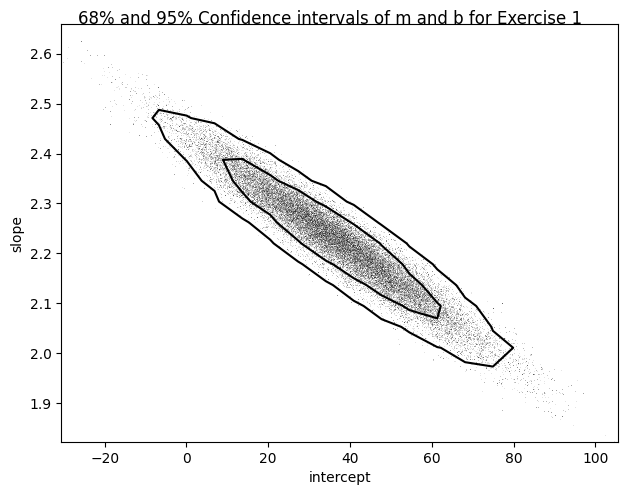

In [6]:
fig = plt.figure()
ax = plot_mcmc(sample.T, fig=fig, labels=["intercept","slope"], colors='k')
ax[0].plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
fig.suptitle("68% and 95% Confidence intervals of m and b for Exercise 1")

<p>From the above, we can see that outer contour representing 95$\%$ and inner 68$\%$ confident intervals. Both contours are almost centred around (slope=2.23,intercept=34.04) which is the predicted slope and intercept after optimization that we got in Assignment - 3 where we were asked to find optimal parameters for fitting line on the above data of Exercise - 1.</p>

<p>Q3. Fit the data in Table 1 of arXiv:1008.4686 to a straight line, after including all the data points, (after ignoring σx and ρxy) using both maximum likelihood analysis and using a Bayesian analysis to identify the outliers, using the same procedure as in the second of Jake VanDerPlas blog article. Show graphically the best fit line using both maximum likelihood analysis and also using Bayesian analysis, including the outlier points.</p>

In [7]:
data_x=np.array([201,244,47,287,203,58,210,202,198,158,165,201,157,131,166,160,186,125,218,146])
data_y=np.array([592,401,583,402,495,173,479,504,510,416,393,442,317,311,400,337,423,334,533,344])
sigma_y=np.array([61,25,38,15,21,15,27,14,30,16,14,25,52,16,34,31,42,26,16,22])
# full data from that table

In [8]:
def linear_function(x,b,m):
    return m*x+b

# Curve_fit does the maximum likelihood analysis and gives us optimal paramters to plot graph without any any special
# consideration about the outliers like huber loss
param = scipy.optimize.curve_fit(linear_function, xdata=data_x, ydata=data_y, sigma=sigma_y)
print("Required parameters for linear model after Chisquare minimization is",param[0])

Required parameters for linear model after Chisquare minimization is [213.2734908    1.07674753]


In [9]:
# frequentist correction to the above is huber loss 
def huber(x, c=3):
    '''Huber loss wixh some default c paramxer'''
    return ((abs(x) < c) * 0.5 * x ** 2
            + (abs(x) >= c) * -c * (0.5 * c - abs(x)))

def huberminimization(param, x, y, e, c=3):
    return huber((y - param[0] - param[1] * x) / e).sum()

param_frq_correction = scipy.optimize.fmin(huberminimization,x0=[0,0], args=(data_x,data_y,sigma_y),disp=False)
print("Required parameters for linear model for frequentist correction is",param_frq_correction)

Required parameters for linear model for frequentist correction is [108.94831388   1.74699242]


C:\Users\Hamesh\AppData\Local\Temp\ipykernel_16464\3049895668.py:13: RuntimeWarning: divide by zero encountered in log
  logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B ** 2) - 0.5 * (dy / sigma_B) ** 2
C:\Users\Hamesh\AppData\Local\Temp\ipykernel_16464\3049895668.py:12: RuntimeWarning: divide by zero encountered in log
  logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e ** 2) - 0.5 * (dy / e) ** 2


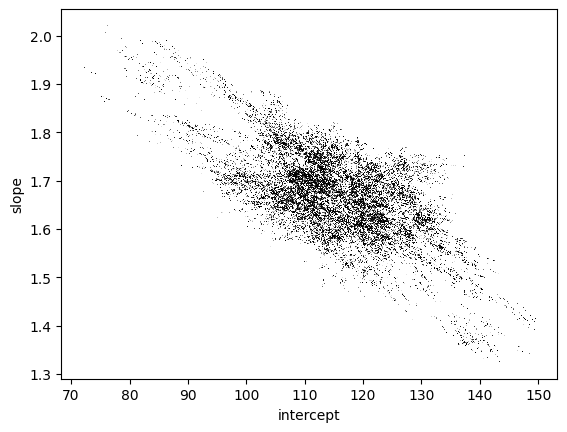

In [10]:
# Bayesian estimation of corresponding parameters
def log_prior(theta):
    #g_i needs to be between 0 and 1
    if (all(theta[2:] > 0) and all(theta[2:] < 1)):
        return 0
    else:
        return -np.inf  # recall log(0) = -inf

def log_likelihood(theta, x, y, e, sigma_B):
    dy = y - theta[0] - theta[1] * x
    g = np.clip(theta[2:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm
    logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e ** 2) - 0.5 * (dy / e) ** 2
    logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B ** 2) - 0.5 * (dy / sigma_B) ** 2
    return np.sum(np.logaddexp(logL1, logL2))

def log_posterior(theta, x, y, e, sigma_B):
    return log_prior(theta) + log_likelihood(theta, x, y, e, sigma_B)

ndim = 2 + len(data_x)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(param_frq_correction, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data_x, data_y, sigma_y, 50])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

plt.plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
plt.xlabel('intercept')
plt.ylabel('slope');

<p>From the above we can clearly see that the paramters are more likely to fall at intercept=115, slope=1.66 as most of the estimates are centred around that (large density of values). Most of the estimated parameters are in region where intercept varies from 95 to 125 and slope varies between 1.55 to 1.8.</p>

g1 mean: 0.55
g2 mean: 0.41


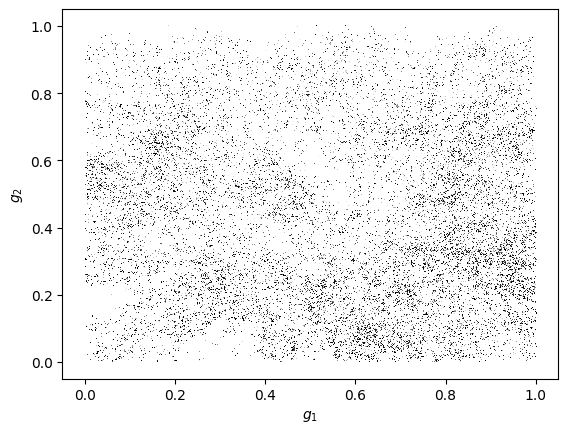

In [11]:
plt.plot(sample[:, 2], sample[:, 3], ',k', alpha=0.1)
plt.xlabel('$g_1$')
plt.ylabel('$g_2$')

print("g1 mean: {0:.2f}".format(sample[:, 2].mean()))
print("g2 mean: {0:.2f}".format(sample[:, 3].mean()))

<p>From the above we can see points are more distributed towards (g1=1,g2=0) so the optimum threshold for g I take is 0.4</p>

In [12]:
bayesian_param = np.mean(sample[:, :2], 0)
print("Required parameters for linear model for Bayesian estimation is",bayesian_param)
g = np.mean(sample[:, 2:], 0)
outliers = (g < 0.4) # outlier detection based on the above said threshold on observing data

Required parameters for linear model for Bayesian estimation is [115.34552298   1.66929277]


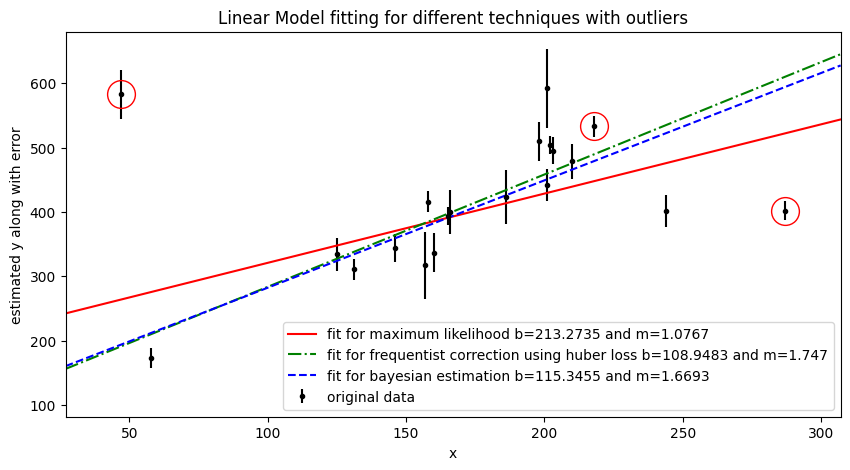

In [13]:
# plotting corresponding plots to compare and also showing outliers
plt.figure(figsize=(10,5))
plt.errorbar(data_x, data_y, sigma_y, label='original data',fmt='.k')
x=np.linspace(0,np.max(data_x)+20,10000)
y=np.zeros(x.shape)
y=param[0][0] + param[0][1]*x  # computing y after getting paramaters 
y_frq_correction=param_frq_correction[0]+param_frq_correction[1]*x
y_bayesain=bayesian_param[0]+bayesian_param[1]*x
plt.xlim(np.min(data_x)-20,np.max(data_x)+20)
plt.plot(x, y, label=f'fit for maximum likelihood b={round(param[0][0],4)} and m={round(param[0][1],4)}',color="red")
plt.plot(x,y_frq_correction,label=f'fit for frequentist correction using huber loss \
b={round(param_frq_correction[0],4)} and m={round(param_frq_correction[1],4)}',color="green",ls='-.')
plt.plot(data_x[outliers], data_y[outliers], 'ro', ms=20, mfc='none', mec='red')
plt.plot(x,y_bayesain,label=f'fit for bayesian estimation b={round(bayesian_param[0],4)} \
and m={round(bayesian_param[1],4)}',color="blue",ls='--')
plt.title("Linear Model fitting for different techniques with outliers")
plt.xlabel('x')
plt.ylabel('estimated y along with error')
plt.legend()
plt.show()